# Sea Level Anomaly Interpolation Using GPSat (GPOD)

This notebook demonstrates the process of using **GPSat** for spatio-temporal interpolation of **Sea Level Anomaly (SLA)** data.

The methodology follows the same processing pipeline used for along-track interpolation. However, instead of focusing on individual tracks, we extend the approach to all available tracks, aiming to fill gaps between them. Additionally, we define the prediction locations to cover the entire **Arctic region**, ensuring comprehensive spatial coverage.

By leveraging GPSat, we can enhance SLA data completeness and improve our understanding of sea level variations in the Arctic.

## Loading dataset and installing dependencies

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

fatal: destination path 'GPSat' already exists and is not an empty directory.
changing directory to: /content/GPSat


In [6]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment


In [7]:
if IN_COLAB:
    !pip install -e .
    !pip install --force-reinstall numpy==1.26.4 pandas==1.5.3 --no-cache-dir


Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Attempting uninstall: GPSat
    Found existing installation: GPSat 0.0.0
    Uninstalling GPSat-0.0.0:
      Successfully uninstalled GPSat-0.0.0
  Running setup.py develop for GPSat
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 146.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 214.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 207.7 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing in

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from datetime import datetime, timedelta
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.postprocessing import smooth_hyperparameters
import GPSat
from GPSat.postprocessing import glue_local_predictions_1d
from GPSat.postprocessing import glue_local_predictions_2d

In [9]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Go from long,lat to x, y
# Define the transformation function
def WGS84toEASE2_Vectorized(lon, lat, return_vals="both", lon_0=0, lat_0=90):
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y

# Go from x,y to long,lat
def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=90):

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat

def get_projection(projection=None):

    # projection
    if projection is None:
        projection = ccrs.NorthPolarStereo()
    elif isinstance(projection, ccrs.Projection):
        pass
    elif isinstance(projection, str):
        if re.search("north", projection, re.IGNORECASE):
            projection = ccrs.NorthPolarStereo()
        elif re.search("south", projection, re.IGNORECASE):
            projection = ccrs.SouthPolarStereo()
        else:
            raise NotImplementedError(f"projection provide as str: {projection}, not implemented")

    return projection

def plot_pcolormesh(ax, lon, lat, plot_data,
                    fig=None,
                    title=None,
                    vmin=None,
                    vmax=None,
                    qvmin=None,
                    qvmax=None,
                    cmap='YlGnBu_r',
                    cbar_label=None,
                    scatter=False,
                    extent=None,
                    ocean_only=False,
                    **scatter_args):

    # ax = axs[j]
    ax.coastlines(resolution='50m', color='white')
    ax.add_feature(cfeat.LAKES, color='white', alpha=.5)
    ax.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))
    extent = [-180, 180, 60, 90] if extent is None else extent
    ax.set_extent(extent, ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

    if title:
        ax.set_title(title)

    if ocean_only:
        if globe_mask is None:
            warnings.warn(f"ocean_only={ocean_only}, however globe_mask is missing, "
                          f"install with pip install global-land-mask")
        else:
            is_in_ocean = globe_mask.is_ocean(lat, lon)
            # copy, just to be safe
            plot_data = copy.copy(plot_data)
            plot_data[~is_in_ocean] = np.nan

    if qvmin is not None:
        if vmin is not None:
            warnings.warn("both qvmin and vmin are supplied, only using qvmin")
        assert (qvmin >= 0) & (qvmin <= 1.0), f"qvmin: {qvmin}, needs to be in [0,1]"
        vmin = np.nanquantile(plot_data, q=qvmin)

    if qvmax is not None:
        if vmax is not None:
            warnings.warn("both qvmax and vmax are supplied, only using qvmax")
        assert (qvmax >= 0) & (qvmax <= 1.0), f"qvmax: {qvmax}, needs to be in [0,1]"
        vmax = np.nanquantile(plot_data, q=qvmax)

    if (vmin is not None) & (vmax is not None):
        assert vmin <= vmax, f"vmin: {vmin} > vmax: {vmax}"

    if not scatter:
        s = ax.pcolormesh(lon, lat, plot_data,
                          cmap=cmap,
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree(),
                          linewidth=0,
                          shading="auto",# to remove DeprecationWarning
                          rasterized=True)
    else:
        non_nan = ~np.isnan(plot_data)
        s = ax.scatter(lon[non_nan],
                       lat[non_nan],
                       c=plot_data[non_nan],
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(),
                       linewidth=0,
                       rasterized=True,
                       **scatter_args)

    if fig is not None:
        cbar = fig.colorbar(s, ax=ax, orientation='horizontal', pad=0.03, fraction=0.03)
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=14)
        cbar.ax.tick_params(labelsize=14)

In [10]:
import pandas as pd

savepath = '/content/drive/MyDrive/GEOL0069/Week 8/'

# Load DataFrame from CSV file
# df = pd.read_csv(savepath+'all_data_01.csv')
GPOD_data = pd.read_csv(savepath+'df_GPOD.csv')

In [11]:
GPOD_data

x             y      t        lon        lat      date  \
0      -3.056178e+06 -1.270463e+06  17907 -67.427184  60.000844  20190111   
1      -3.055943e+06 -1.270243e+06  17907 -67.429148  60.003653  20190111   
2      -3.055707e+06 -1.270022e+06  17907 -67.431112  60.006463  20190111   
3      -3.055472e+06 -1.269801e+06  17907 -67.433077  60.009272  20190111   
4      -3.055236e+06 -1.269580e+06  17907 -67.435042  60.012081  20190111   
...              ...           ...    ...        ...        ...       ...   
414747 -6.343986e+05 -4.106771e+05  17909 -57.083051  83.229731  20190113   
414748 -6.346926e+05 -4.107562e+05  17909 -57.090123  83.227131  20190113   
414749 -6.349865e+05 -4.108354e+05  17909 -57.097191  83.224532  20190113   
414750 -6.352805e+05 -4.109145e+05  17909 -57.104252  83.221933  20190113   
414751 -6.355744e+05 -4.109936e+05  17909 -57.111309  83.219333  20190113   

       class  interpSLA  elevation  SAT  track  
0       lead        NaN     0.4397  S3A      0  
1       lead     0.4207     0.4250  S3A      0  
2       lead     0.4201     0.4296  S3A      0  
3       lead     0.4195     0.4494  S3A      0  
4       lead     0.4190     0.4171  S3A      0  
...      ...        ...        ...  ...    ...  
414747  floe        NaN     0.0195  CS2    152  
414748  floe        NaN        NaN  CS2    152  
414749  floe        NaN     0.3082  CS2    152  
414750  floe        NaN     0.1651  CS2    152  
414751  floe        NaN     0.1292  CS2    152  

[414752 rows x 11 columns]

In [12]:
from datetime import datetime, timedelta


# Initialise an empty DataFrame to hold all data
all_data_df = pd.DataFrame()

# Extract spatial and temporal information
lon = GPOD_data['lon']
lat = GPOD_data['lat']
time = GPOD_data['date']
interpSLA = GPOD_data['interpSLA']

# Convert time to datetime objects
base_time = datetime(2000, 1, 1)
datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])

# Convert lon, lat to EASE-2 Grid
transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
                                    "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
x, y = transformer.transform(lon, lat)

# Create a DataFrame for this file
all_data_df = pd.DataFrame({
    'x': x,
    'y': y,
    't': (pd.to_datetime(datetimes) - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D'),
    'SLA': interpSLA
})

# Drop rows where 'obs' is NaN
all_data_df.dropna(subset=['SLA'], inplace=True)

# Now all_data_df contains concatenated data from all files
print(all_data_df)


                   x             y             t     SLA
1      -3.055943e+06 -1.270243e+06  11190.681840  0.4207
2      -3.055707e+06 -1.270022e+06  11190.681840  0.4201
3      -3.055472e+06 -1.269801e+06  11190.681840  0.4195
4      -3.055236e+06 -1.269580e+06  11190.681840  0.4190
5      -3.055000e+06 -1.269359e+06  11190.681840  0.4184
...              ...           ...           ...     ...
414741 -6.314591e+05 -4.098858e+05  11190.681863 -0.0571
414742 -6.317530e+05 -4.099649e+05  11190.681863 -0.0571
414743 -6.320470e+05 -4.100441e+05  11190.681863 -0.0572
414744 -6.332228e+05 -4.103606e+05  11190.681863 -0.0574
414745 -6.335168e+05 -4.104397e+05  11190.681863 -0.0575

[399613 rows x 4 columns]


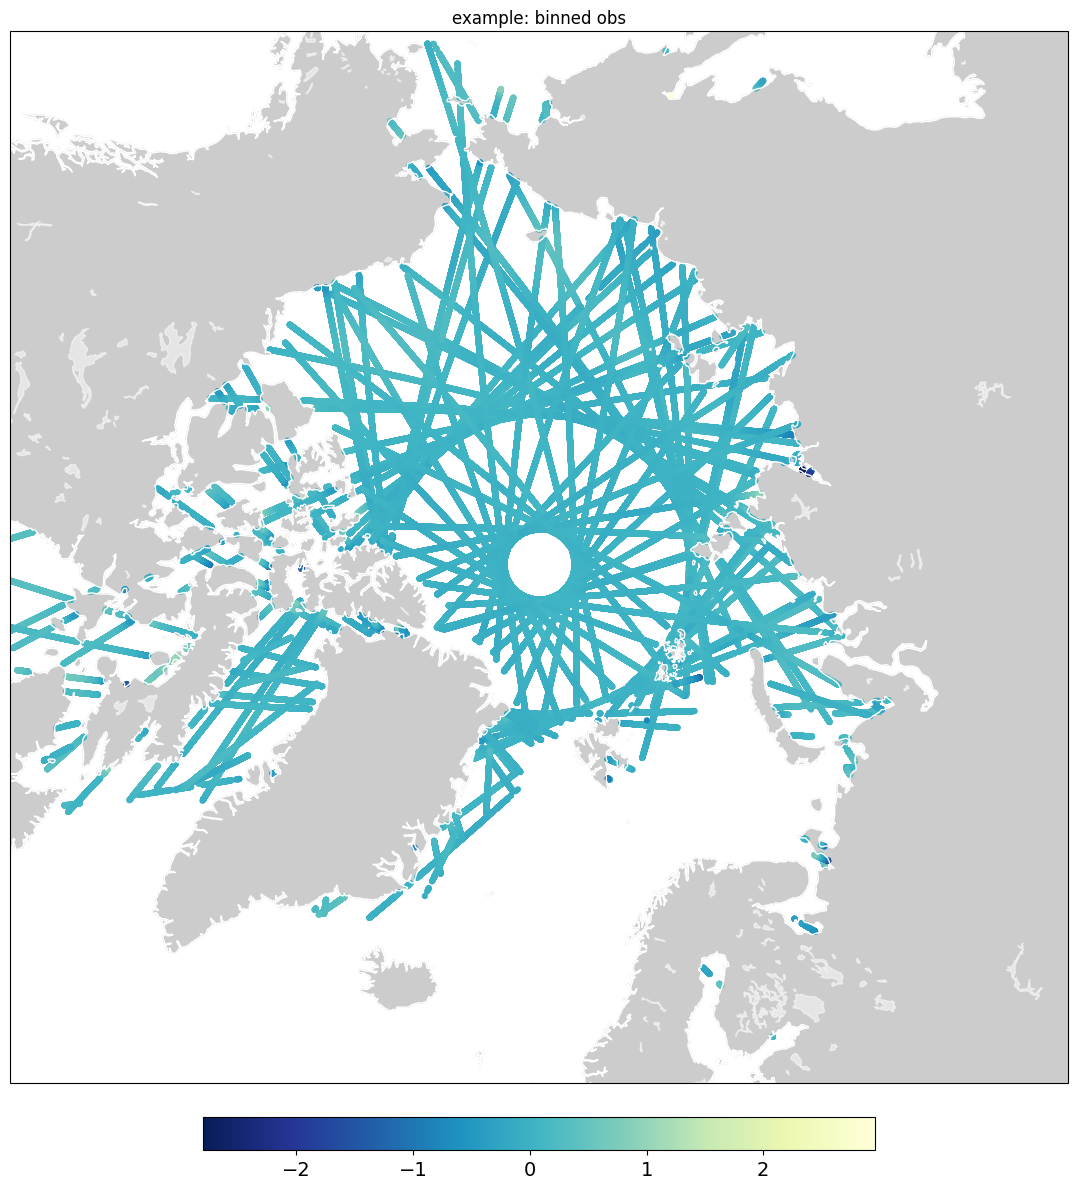

In [13]:
import re
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


all_data_df['lon'], all_data_df['lat'] = EASE2toWGS84(all_data_df['x'], all_data_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=all_data_df['lon'],
                lat=all_data_df['lat'],
                plot_data=all_data_df['SLA'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

# Assuming df is already defined and contains the data
columns_to_extract = {
    'x': 'x',
    'y': 'y',
    't': 't',
    'SLA': 'z'
}
df = all_data_df[list(columns_to_extract.keys())].rename(columns=columns_to_extract)

# Check the first few rows to confirm the data was loaded correctly
print(df.head())



              x             y            t       z
1 -3.055943e+06 -1.270243e+06  11190.68184  0.4207
2 -3.055707e+06 -1.270022e+06  11190.68184  0.4201
3 -3.055472e+06 -1.269801e+06  11190.68184  0.4195
4 -3.055236e+06 -1.269580e+06  11190.68184  0.4190
5 -3.055000e+06 -1.269359e+06  11190.68184  0.4184


## Define variables and settings for GPSat

In [15]:
# lat,lon center (origin) used for converting between WGS84 and EASE2 projections
lat_0 = 90
lon_0 = 0

# expert location parameters
# spacing between experts (laid out on a grid), in meters
expert_spacing = 200_000
# range of experts, from origin, in meters
# expert_x_range = [-750_000.0, 1000_000.0]
# expert_y_range = [-500_000.0, 1250_000.0]
expert_x_range = [-3100_000, 3100_000]
expert_y_range = [-3100_000, 3100_000]

# prediction spacing
# (below predictions same range as experts)
pred_spacing = 5_000


# model parameters
# Set training and inference radius
# - distance observations need to be away from expert locations to be included in training
training_radius = 300_000  # 300km
# - distance prediction locations need to be away from expert locations in order of predictions to be made
inference_radius = 200_000  # 200km


# plotting
# extent = [lon min, lat max, lat min, lat max]
extent = [-180, 180, 60, 90]

# which projection to use: "north" or "south"
projection = "north"

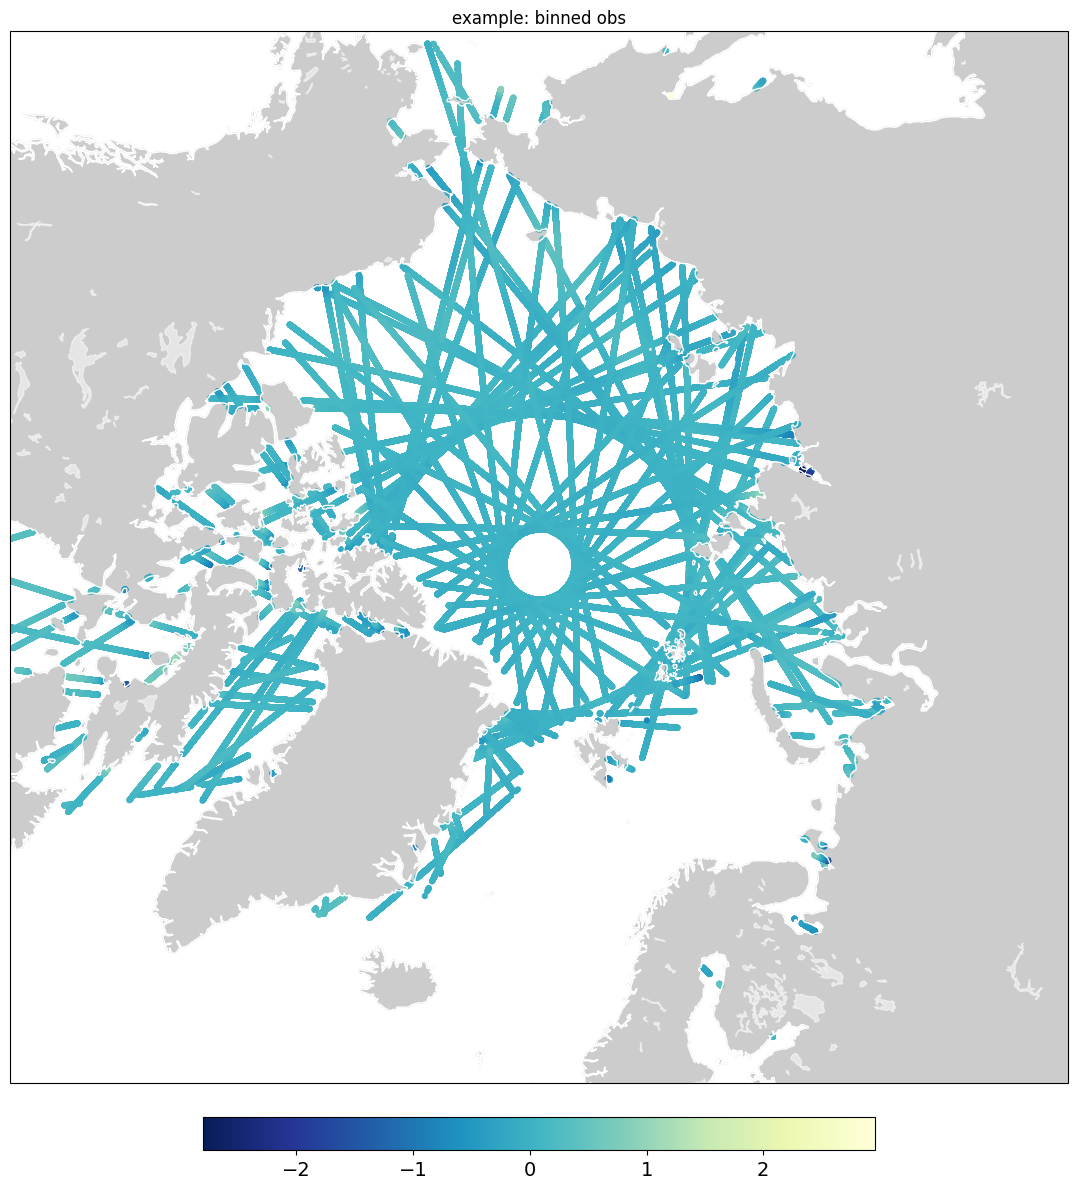

In [16]:
df['lon'], df['lat'] = EASE2toWGS84(df['x'], df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=df['lon'],
                lat=df['lat'],
                plot_data=df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [17]:
xy_grid = grid_2d_flatten(x_range=expert_x_range,
                          y_range=expert_y_range,
                          step_size=expert_spacing)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

Local expert locations:


x          y        t
0 -3000000.0 -3000000.0  11190.0
1 -2800000.0 -3000000.0  11190.0
2 -2600000.0 -3000000.0  11190.0
3 -2400000.0 -3000000.0  11190.0
4 -2200000.0 -3000000.0  11190.0

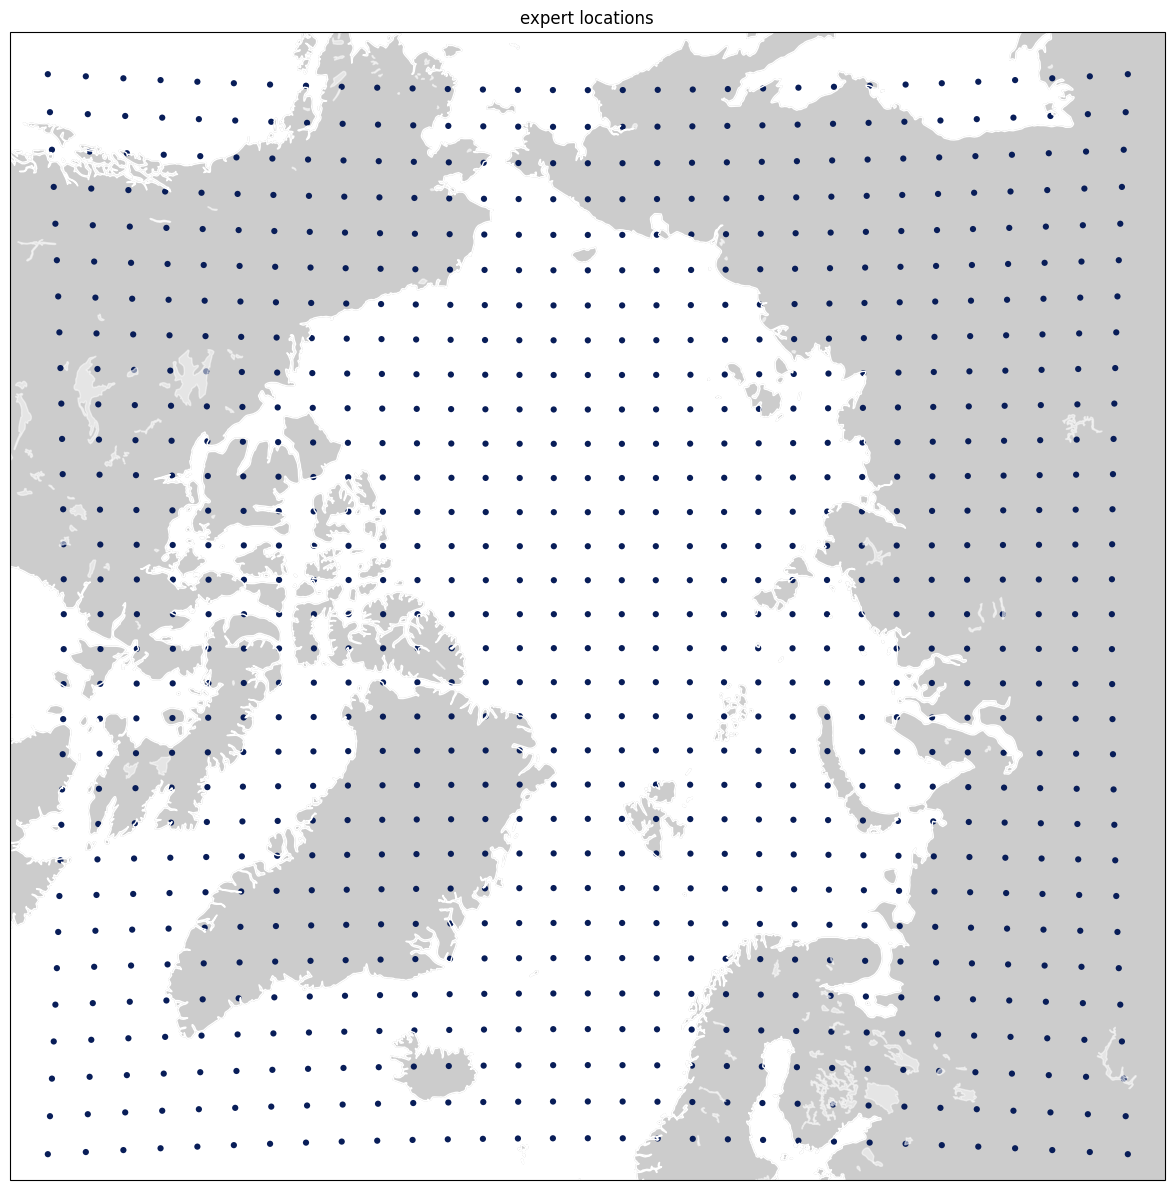

In [18]:
# plot expert locations
eloc['lon'], eloc['lat'] = EASE2toWGS84(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [19]:
from global_land_mask import globe
pred_xy_grid = grid_2d_flatten(x_range=expert_x_range,
                               y_range=expert_y_range,
                               step_size=pred_spacing)
# Load test locations
test_locs = pd.read_csv('/content/drive/MyDrive/GEOL0069/Week 8/test_locs.csv')
# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
# ploc = pd.DataFrame(pred_xy_grid, columns=['x', 'y'])

# ploc['lon'], ploc['lat'] = EASE2toWGS84(ploc['x'], ploc['y'],
#                                         lat_0=lat_0, lon_0=lon_0)
ploc = test_locs
# identify if a position is in the ocean (water) or not
ploc["is_in_ocean"] = globe.is_ocean(ploc['lat'], ploc['lon'])

# keep only prediction locations in ocean
ploc = ploc.loc[ploc["is_in_ocean"]]

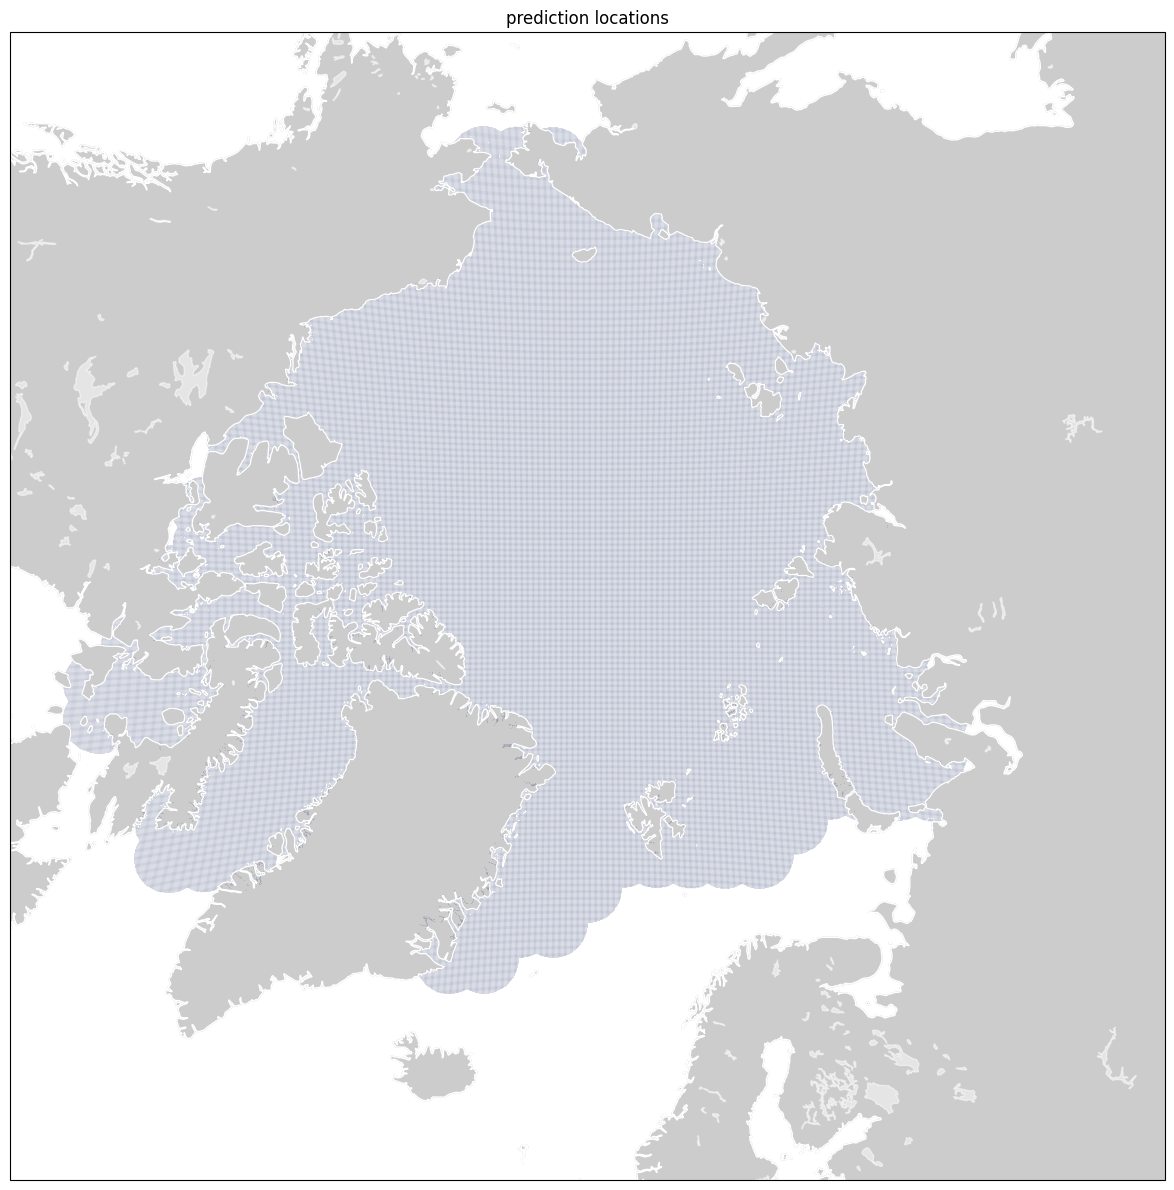

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


In [21]:
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()

bin_df.head()

'bin_data_by': 1.008 seconds


y          x             t         z
0 -2925000.0  1425000.0  11190.681933  0.123950
1 -2925000.0  1475000.0  11190.681933  0.149100
2 -2625000.0  1125000.0  11190.681933  0.508380
3 -2575000.0  1025000.0  11190.681933 -0.301057
4 -2575000.0  1075000.0  11190.681933 -0.235431

In [22]:
bin_df.shape

(4477, 4)

<ipython-input-23-983b1d6bc006>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])


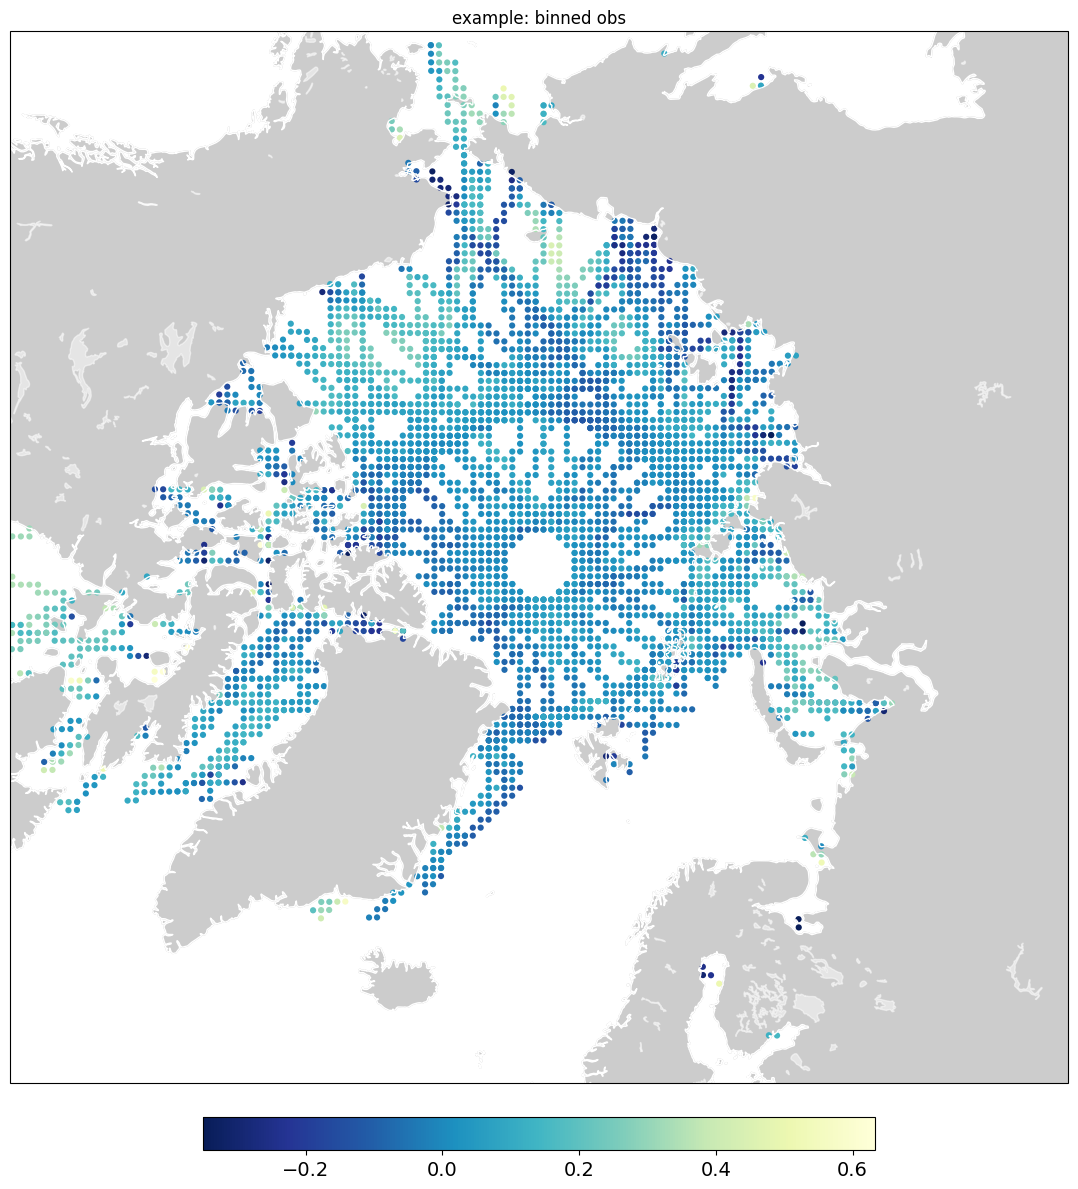

In [23]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [24]:
# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": training_radius
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowSGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1],
        "num_inducing_points": 100
        # can specify initial parameters values for model:
        # "noise_variance": 0.10,
        # "kernel_kwargs": {
        #     "lengthscales": [2.0, 2.0, 1.0],
        #     "variance": 0.05
        # }
    },
    # keyword arguments to be passed into each model/local expert's optimise_parameters method
    "optim_kwargs": {
        # parameters to be fixed (not trainable)
        # "fixed_params": ["likelihood_variance"]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        # - given in unscaled units
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        },
        "likelihood_variance": {
            "low": 0.00125,
            "high": 0.01
        }
    }
}

# prediction locations
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": inference_radius
}

### Sparse Gaussian Process (SGPR) in GPSat

### **Switching from Standard GPR to Sparse GPR**
If you want to make our Gaussian Process model more scalable (speed up), we replace **GPR** with **SGPR**, using **inducing points** to reduce computation time.

#### **Standard GP Model**
```python
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        "coords_scale": [50000, 50000, 1],  
    },
}
```
#### Sparse GP Model
```python
model = {
    "oi_model": "GPflowSGPRModel",
    "init_params": {
        "coords_scale": [50000, 50000, 1],
        "num_inducing_points": 100,  
    },
}
```

## Train GPSat model and plotting

In [25]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation
# - no predictions locations supplied
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}", "FAIL")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True,
           check_config_compatible=False)

流式输出内容被截断，只能显示最后 5000 行内容。
'set_likelihood_variance_constraints': 0.052 seconds
'optimise_parameters': 1.342 seconds
'optimise_parameters': 1.342 seconds
'get_parameters': 0.014 seconds
parameters:
lengthscales: array([11.99520625, 11.99992446,  0.99669913]) 
kernel_variance: 0.001146785673281184
likelihood_variance: 0.009314479243643035
inducing_points: array([[  -39.5       ,    19.5       , 11190.68193287],
       [  -38.5       ,    19.5       , 11190.68193287],
       [  -41.5       ,    20.5       , 11190.68184028],
       [  -40.5       ,    20.5       , 11190.68184028],
       [  -40.5       ,    20.5       , 11190.68193287]]) (truncated) 
'predict': 0.147 seconds
total run time : 3.31 seconds
--------------------------------------------------
626 / 961
current local expert:
             x          y        t         lon        lat
625 -2000000.0  1000000.0  11190.0 -116.565051  69.868945
'local_data_select': 0.003 seconds
number obs: 23
found GPU
setting lengthscales to: [1. 1

In [1]:
# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")

NameError: name 'get_results_from_h5file' is not defined

In [27]:
preds_data = dfs["preds"]

preds_data.head()

x          y        t  _dim_0        f*    f*_var     y_var  f_bar  \
0 -1000000.0 -2200000.0  11190.0       0 -0.002346  0.030747  0.031997      0   
1 -1000000.0 -2200000.0  11190.0       1 -0.001833  0.030790  0.032040      0   
2 -1000000.0 -2200000.0  11190.0       2 -0.002654  0.030642  0.031892      0   
3 -1000000.0 -2200000.0  11190.0       3 -0.002151  0.030675  0.031925      0   
4 -1000000.0 -2200000.0  11190.0       4 -0.001646  0.030712  0.031962      0   

   pred_loc_x  pred_loc_y  pred_loc_t        lon        lat  
0   -977500.0  -2087500.0     11190.0 -24.443955  68.223016  
1   -977500.0  -2082500.0     11190.0 -24.443955  68.223016  
2   -972500.0  -2097500.0     11190.0 -24.443955  68.223016  
3   -972500.0  -2092500.0     11190.0 -24.443955  68.223016  
4   -972500.0  -2087500.0     11190.0 -24.443955  68.223016

In [28]:
# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()

pred_loc_x  pred_loc_y        f*    f*_var
0  -2997500.0   -627500.0  0.178505  0.030074
1  -2997500.0   -622500.0  0.173281  0.030089
2  -2997500.0   -617500.0  0.168776  0.030136
3  -2997500.0   -612500.0  0.164984  0.030211
4  -2997500.0   -607500.0  0.161886  0.030309

In [4]:

from GPSat.utils import EASE2toWGS84_New

lon_vals, lat_vals = EASE2toWGS84_New(
    plt_data["pred_loc_x"],
    plt_data["pred_loc_y"]
)


plt_data["longitude"] = lon_vals
plt_data["latitude"] = lat_vals


output_csv = "/content/drive/MyDrive/GEOL0069/Week 8/freeboard_prediction_converted.csv"
plt_data.to_csv(output_csv, index=False)


NameError: name 'plt_data' is not defined

In [3]:
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"})
plt.tight_layout()
plt.show()

NameError: name 'plt_data' is not defined

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


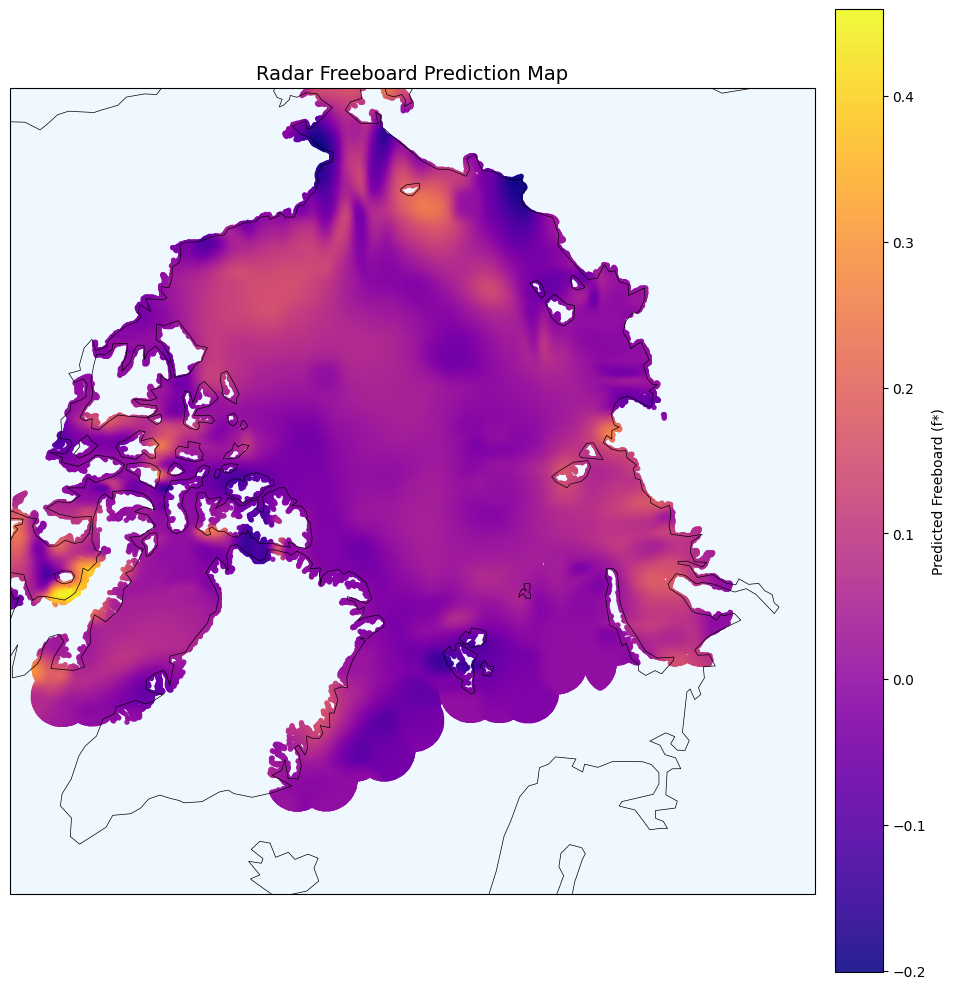

In [30]:

!pip install cartopy


import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat


data_path = "/content/drive/MyDrive/GEOL0069/Week 8/freeboard_prediction_converted.csv"
pred_df = pd.read_csv(data_path)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())


ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m", color="black", linewidth=0.5)
ax.add_feature(cfeat.LAND, facecolor='lightgray')
ax.add_feature(cfeat.OCEAN, facecolor='aliceblue')


scatter = ax.scatter(
    pred_df["longitude"],
    pred_df["latitude"],
    c=pred_df["f*"],
    s=8,
    cmap="plasma",
    transform=ccrs.PlateCarree(),
    alpha=0.9
)


cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Predicted Freeboard (f*)")

plt.title("Radar Freeboard Prediction Map", fontsize=14)
plt.tight_layout()
plt.show()
